### Data process

In [1]:
import torch as t
import numpy as np
from PIL import Image
from sklearn import svm
from sklearn.cross_validation import train_test_split
from sklearn.feature_extraction import DictVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn import metrics
import lightgbm as lgb
import matplotlib.pyplot as plot
from data.ml_dataset import BODataSet
import time
import os
import torch.nn as nn
import random

C:\Users\10426\Anaconda3\envs\pytorch\lib\site-packages\sklearn\cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [2]:
# get dataset
dataset = BODataSet(root="./data/train")
class_labels = ('normal', 'hypopnea', 'apnea')
X, Y = dataset.get_data()
train_X, test_X, train_Y, test_Y = train_test_split(X, Y, test_size=0.3, random_state=33)
len(train_X), len(test_X)
train_X[0]

array([  9.90000000e+01,   9.60000000e+01,   9.71000000e+01,
         1.02333333e+00,   1.01159939e+00,   9.70000000e+01,
         1.04181194e-02,   1.01956746e+00,   9.88671473e-01,
         9.11666053e-02,  -1.56306058e+00,  -5.00000000e-02,
         4.83050847e-02,  -1.00000000e+00,  -4.23613061e+00,
         1.64937753e+01,   1.00000000e+00,   0.00000000e+00,
         3.00000000e+00,   9.71000000e+01,   1.04067797e+00,
         9.90000000e+01,   9.60000000e+01,   9.11666053e-02,
        -1.56306058e+00])

In [3]:
# data enhance
def upsampling(frags, labels):
        class_count = [0, 0, 0]
        for label in labels:
            class_count[label] += 1
        class_max = max(class_count)
        print(class_count, class_max)

        for i in range(len(frags)):
            duplicate = class_max / class_count[labels[i]] - 1
            duplicate_integer = int(duplicate)
            duplicate_decimal = duplicate - int(duplicate)
            # print(self.frags[i][1], duplicate_integer, duplicate_decimal)

            frags.extend([frags[i] for x in range(duplicate_integer)])
            labels.extend([labels[i] for x in range(duplicate_integer)])
            if random.uniform(0, 1) < duplicate_decimal:
                frags.append(frags[i])
                labels.append(labels[i])

        class_count = [0, 0, 0]
        for label in labels:
            class_count[label] += 1
        print(class_count)
        return frags

upsampling(train_X, train_Y)
#upsampling(test_X, test_Y)
len(train_X)

[72, 9, 5] 72
[72, 72, 74]


218

### 数据预处理
归一化，二值化等操作

In [4]:
from sklearn import preprocessing

min_max_scale = preprocessing.MinMaxScaler()
X_scale = min_max_scale.fit_transform(X)
test_X_scale = min_max_scale.fit_transform(test_X)

X_normalize = preprocessing.normalize(X)
test_X_normalize = preprocessing.normalize(test_X)
train_X[0].shape

(25,)

In [5]:
# test code
def test(clf, X, Y):
    class_labels = ('normal', 'hypopnea', 'apnea')
    class_total = [0, 0, 0]
    class_correct = [0, 0, 0]
    pre_Y = clf.predict(X)
    prediction = (pre_Y == Y)
    for index in range(len(Y)):
        label = Y[index]
        class_total[label] += 1
        class_correct[label] += prediction[index]
    
    accs = []
    accs.append("Total %d events accuracy: %.1f %%"%(sum(class_total), sum(class_correct) / sum(class_total) *100))
    accs.append("Total %d abnormal accuracy: %.1f %%" %(class_total[1]+class_total[2], (class_correct[1]+class_correct[2])/(class_total[1]+class_total[2]) *100))
    accs.extend(["%s %d events accuracy: %.1f %%" %(class_labels[i], class_total[i], class_correct[i] / class_total[i] *100 if class_total[i] != 0 else -1) for i in range(3)])
    print('\n'.join(accs), "\n")
    
    
    print("Precision_score: %.1f " % (metrics.precision_score(Y, pre_Y, average='weighted')*100))
    print("recall_score: %.1f " % (metrics.recall_score(Y, pre_Y, average='weighted')*100))
    print("f1_score: %.1f " % (metrics.f1_score(Y, pre_Y, average='weighted')*100))
    return pre_Y

# calculate accuracy
def calc_accuracy(Y, pre_Y):
    class_labels = ('normal', 'hypopnea', 'apnea')
    class_total = [0, 0, 0]
    class_correct = [0, 0, 0]
    prediction = (pre_Y == Y)
    #print(prediction)
    for index in range(len(Y)):
        label = Y[index]
        class_total[label] += 1
        class_correct[label] += prediction[index]
    
    accs = []
    accs.append("Total %d events accuracy: %.1f %%"%(sum(class_total), sum(class_correct) / sum(class_total) *100))
    accs.append("Total %d abnormal accuracy: %.1f %%" %(class_total[1]+class_total[2], (class_correct[1]+class_correct[2])/(class_total[1]+class_total[2]) *100))
    accs.extend(["%s %d events accuracy: %.1f %%" %(class_labels[i], class_total[i], class_correct[i] / class_total[i] *100 if class_total[i] != 0 else -1) for i in range(3)])
    
    print('\n'.join(accs), "\n")
    
    print("Precision_score: %.1f " % (metrics.precision_score(Y, pre_Y, average='weighted')*100))
    print("recall_score: %.1f " % (metrics.recall_score(Y, pre_Y, average='weighted')*100))
    print("f1_score: %.1f " % (metrics.f1_score(Y, pre_Y, average='weighted')*100))
    

### SVM

In [6]:

svm_clf = svm.SVC()
param_grid = {'C': [1e-3, 1e-2, 1e-1, 1, 10, 100, 1000], 'gamma':[0.0001, 0.001, 0.01, 0.1, 0.3],}

svm_clf_cv = GridSearchCV(svm.SVC(decision_function_shape='ovo', kernel='rbf'),param_grid, n_jobs=8, verbose=2, scoring='f1_macro')
svm_clf_cv.fit(X,Y)

svm_clf = svm.SVC(decision_function_shape='ovo', C=svm_clf_cv.best_params_['C'], gamma=svm_clf_cv.best_params_['gamma'])
svm_clf.fit(train_X, train_Y)

test(svm_clf, test_X, test_Y)


print(svm_clf_cv.best_params_['C'], svm_clf_cv.best_params_['gamma'])

C:\Users\10426\Anaconda3\envs\pytorch\lib\site-packages\sklearn\model_selection\_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)


Fitting 3 folds for each of 35 candidates, totalling 105 fits


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  25 tasks      | elapsed:    4.5s
[Parallel(n_jobs=8)]: Done 105 out of 105 | elapsed:    6.1s finished
C:\Users\10426\Anaconda3\envs\pytorch\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Total 38 events accuracy: 76.3 %
Total 9 abnormal accuracy: 55.6 %
normal 29 events accuracy: 82.8 %
hypopnea 6 events accuracy: 66.7 %
apnea 3 events accuracy: 33.3 % 

Precision_score: 80.3 
recall_score: 76.3 
f1_score: 77.9 
10 0.001


In [7]:
import pylab as pl

In [8]:
svm_clf.fit(train_X,train_Y)
test(svm_clf, test_X, test_Y)
len(svm_clf.support_vectors_)

Total 38 events accuracy: 76.3 %
Total 9 abnormal accuracy: 55.6 %
normal 29 events accuracy: 82.8 %
hypopnea 6 events accuracy: 66.7 %
apnea 3 events accuracy: 33.3 % 

Precision_score: 80.3 
recall_score: 76.3 
f1_score: 77.9 


125

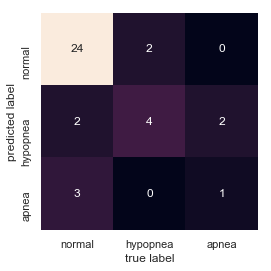

In [9]:
# confusion matrix 
# https://jakevdp.github.io/PythonDataScienceHandbook/05.07-support-vector-machines.html

import matplotlib.pyplot as plt
from scipy import stats

# use seaborn plotting defaults
import seaborn as sns; sns.set()

from sklearn.metrics import confusion_matrix

pre = svm_clf.predict(test_X)
mat = confusion_matrix(test_Y, pre)
sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False,
            xticklabels=class_labels,
            yticklabels=class_labels)
# plt.figure()
plt.xlabel('true label')
plt.ylabel('predicted label');
plt.rcParams['figure.dpi'] = 100 #分辨率
plt.savefig("./cm_svm")
# plt.rcParams.update({'font.size': 40})
# plt.show()

### RandomForest

In [10]:
#print(clf.best_estimator_.get_params())
best_rf_model = RandomForestClassifier(max_depth=20, max_features=0.7, criterion='gini', max_leaf_nodes=500, min_samples_leaf=1, min_samples_split=2, n_estimators=10)
best_rf_model.fit(train_X, train_Y)
test(best_rf_model, test_X, test_Y)
best_rf_model.feature_importances_

Total 38 events accuracy: 84.2 %
Total 9 abnormal accuracy: 44.4 %
normal 29 events accuracy: 96.6 %
hypopnea 6 events accuracy: 50.0 %
apnea 3 events accuracy: 33.3 % 

Precision_score: 84.7 
recall_score: 84.2 
f1_score: 83.1 


array([ 0.01218614,  0.        ,  0.01772559,  0.04060984,  0.10293178,
        0.00507227,  0.11767906,  0.02592354,  0.0487541 ,  0.09892438,
        0.02726272,  0.        ,  0.00115307,  0.        ,  0.01292264,
        0.05631949,  0.00206557,  0.00222067,  0.        ,  0.00589913,
        0.06581118,  0.        ,  0.        ,  0.31595367,  0.04058515])

### Xgboost

In [11]:
import xgboost as xgb
from xgboost import XGBClassifier

params = {
    'booster': 'gbtree',
    'objective': 'multi:softmax',  # 多分类的问题
    'num_class': 3,               # 类别数，与 multisoftmax 并用
    'gamma': 0.1,                  # 用于控制是否后剪枝的参数,越大越保守，一般0.1、0.2这样子。
    'max_depth': 12,               # 构建树的深度，越大越容易过拟合
    'lambda': 2,                   # 控制模型复杂度的权重值的L2正则化项参数，参数越大，模型越不容易过拟合。
    'subsample': 0.7,              # 随机采样训练样本
    'colsample_bytree': 0.7,       # 生成树时进行的列采样
    'min_child_weight': 3,
    'silent': 1,                   # 设置成1则没有运行信息输出，最好是设置为0.
    'eta': 0.1,                  # 如同学习率
    'seed': 1000,
    'nthread': 4,                  # cpu 线程数
}
plst = params.items()

dtrain = xgb.DMatrix(train_X, train_Y)
d_test_X = xgb.DMatrix(test_X)
model = xgb.train(plst, dtrain, 100)

test(model, d_test_X, test_Y)

Total 38 events accuracy: 86.8 %
Total 9 abnormal accuracy: 44.4 %
normal 29 events accuracy: 100.0 %
hypopnea 6 events accuracy: 50.0 %
apnea 3 events accuracy: 33.3 % 

Precision_score: 86.5 
recall_score: 86.8 
f1_score: 85.1 


array([ 0.,  0.,  0.,  0.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,  2.,  0.,
        1.,  0.,  1.,  0.,  0.,  0.,  0.,  0.,  1.,  0.,  0.,  1.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.], dtype=float32)

In [12]:
xgb_clf = XGBClassifier(learning_rate=0.1)
xgb_clf.fit(np.array(train_X), train_Y)

test(xgb_clf, np.array(test_X), test_Y)

Total 38 events accuracy: 86.8 %
Total 9 abnormal accuracy: 44.4 %
normal 29 events accuracy: 100.0 %
hypopnea 6 events accuracy: 50.0 %
apnea 3 events accuracy: 33.3 % 

Precision_score: 86.5 
recall_score: 86.8 
f1_score: 85.1 


array([0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 2, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0,
       0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

### LGB

In [13]:
# light gbn models
train_data = lgb.Dataset(np.array(train_X), train_Y)
test_data = lgb.Dataset(np.array(test_X), label=test_Y)

params = {
    'task': 'train',
    'n_estimators': 30,
    'objective': 'multiclass',
    'max_depth': 50,
    'num_class': 3,
#     'metric': 'auc',
    'learning_rate': 0.1,
#     'verbose': 0
}

bst = lgb.train(params, train_data, valid_sets=test_data)

y_pred = bst.predict(test_X)
y_pred = np.array([list(e).index(max(e)) for e in y_pred])

calc_accuracy(test_Y, y_pred)
# bst.save_model('model.txt')
# json_model = bst.dump_model()
# bst = lgb.Booster(model_file='model.txt')


C:\Users\10426\Anaconda3\envs\pytorch\lib\site-packages\lightgbm\engine.py:113: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[1]	valid_0's multi_logloss: 1.01143
[2]	valid_0's multi_logloss: 0.939509
[3]	valid_0's multi_logloss: 0.880915
[4]	valid_0's multi_logloss: 0.829043
[5]	valid_0's multi_logloss: 0.785832
[6]	valid_0's multi_logloss: 0.747312
[7]	valid_0's multi_logloss: 0.715385
[8]	valid_0's multi_logloss: 0.688172
[9]	valid_0's multi_logloss: 0.662761
[10]	valid_0's multi_logloss: 0.641067
[11]	valid_0's multi_logloss: 0.623521
[12]	valid_0's multi_logloss: 0.606435
[13]	valid_0's multi_logloss: 0.589468
[14]	valid_0's multi_logloss: 0.574224
[15]	valid_0's multi_logloss: 0.559287
[16]	valid_0's multi_logloss: 0.547491
[17]	valid_0's multi_logloss: 0.531733
[18]	valid_0's multi_logloss: 0.519891
[19]	valid_0's multi_logloss: 0.508109
[20]	valid_0's multi_logloss: 0.497674
[21]	valid_0's multi_logloss: 0.488815
[22]	valid_0's multi_logloss: 0.479692
[23]	valid_0's multi_logloss: 0.474293
[24]	valid_0's multi_logloss: 0.467051
[25]	valid_0's multi_logloss: 0.460079
[26]	valid_0's multi_logloss: 0.454

### KNN

In [14]:
from sklearn.neighbors import KNeighborsClassifier
knn = KNeighborsClassifier(n_neighbors=1, p=5, metric='minkowski')
knn.fit(train_X,train_Y)

test(knn, test_X, test_Y)

Total 38 events accuracy: 78.9 %
Total 9 abnormal accuracy: 55.6 %
normal 29 events accuracy: 86.2 %
hypopnea 6 events accuracy: 50.0 %
apnea 3 events accuracy: 66.7 % 

Precision_score: 79.2 
recall_score: 78.9 
f1_score: 78.9 


array([1, 0, 0, 0, 1, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 2, 0, 0, 1, 0, 0, 2, 0,
       0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 1])

### Decision Tree

In [15]:
from sklearn.tree import DecisionTreeClassifier

decision_tree = DecisionTreeClassifier(criterion='entropy', max_depth=10, random_state=10)
decision_tree.fit(train_X, train_Y)

test(decision_tree, test_X, test_Y)

Total 38 events accuracy: 84.2 %
Total 9 abnormal accuracy: 33.3 %
normal 29 events accuracy: 100.0 %
hypopnea 6 events accuracy: 33.3 %
apnea 3 events accuracy: 33.3 % 

Precision_score: 82.9 
recall_score: 84.2 
f1_score: 81.7 


array([0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0,
       0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

In [16]:
# features importance
names = ['zero', 'max_v', 'min_v', 'v_range', 'gap', 'mean', 'var', 'std', 'med', 'avg_m_std', 'max_m_avg', 'min_m_avg', 'skew', 'kurt', 'hr_low_than_60', 'hr_high_than_100', 'hr_normal', 'diff_mean', 'diff_var', 'diff_max_v', 'diff_min_v', 'diff_skew', 'diff_kurt', 'diff_range', 'diffargmax', 'diffargmin', 'mean_big_0', 'var_big_0', 'max_big_0', 'min_big_0', 'skew_big_0', 'kurt_big_0', 'diff_range_big_0']
dt_importances = sorted(zip(map(lambda x: round(x, 4), decision_tree.feature_importances_), names), reverse=True)
rf_importances = sorted(zip(map(lambda x: round(x, 4), best_rf_model.feature_importances_), names), reverse=True)
xgb_fscore = model.get_fscore()
temp1 = []
temp2 = []
for k in xgb_fscore:
    temp1.append(names[int(k[1:]) -1])
    temp2.append(xgb_fscore[k])

xgb_importances = sorted(zip(temp2, temp1), reverse=True)

xgb_importances[-10:], dt_importances[-10:], rf_importances[-10:]

([(34, 'var'),
  (34, 'hr_normal'),
  (28, 'diff_kurt'),
  (20, 'gap'),
  (17, 'diff_var'),
  (16, 'v_range'),
  (11, 'max_m_avg'),
  (5, 'mean'),
  (4, 'zero'),
  (2, 'diff_skew')],
 [(0.0, 'kurt'),
  (0.0, 'hr_normal'),
  (0.0, 'hr_low_than_60'),
  (0.0, 'gap'),
  (0.0, 'diff_var'),
  (0.0, 'diff_skew'),
  (0.0, 'diff_min_v'),
  (0.0, 'diff_mean'),
  (0.0, 'diff_max_v'),
  (0.0, 'diff_kurt')],
 [(0.0051000000000000004, 'mean'),
  (0.0022000000000000001, 'diff_mean'),
  (0.0020999999999999999, 'hr_normal'),
  (0.0011999999999999999, 'skew'),
  (0.0, 'min_m_avg'),
  (0.0, 'max_v'),
  (0.0, 'kurt'),
  (0.0, 'diff_var'),
  (0.0, 'diff_skew'),
  (0.0, 'diff_kurt')])

### Model fusion

In [17]:
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier, VotingClassifier

eclf = VotingClassifier(estimators=[('svm', svm_clf), ('rf', best_rf_model)])
eclf = eclf.fit(train_X,train_Y)
pre_Y = test(eclf, test_X, test_Y)

Total 38 events accuracy: 84.2 %
Total 9 abnormal accuracy: 33.3 %
normal 29 events accuracy: 100.0 %
hypopnea 6 events accuracy: 50.0 %
apnea 3 events accuracy: 0.0 % 



C:\Users\10426\Anaconda3\envs\pytorch\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


Precision_score: 77.1 
recall_score: 84.2 


C:\Users\10426\Anaconda3\envs\pytorch\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


f1_score: 80.5 


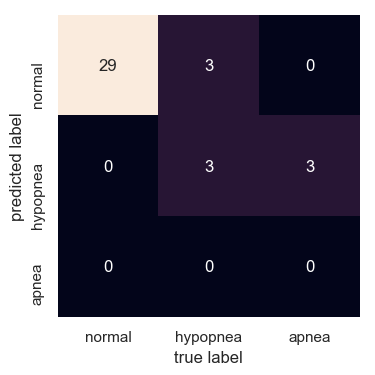

In [18]:
# confusion matrix 
# https://jakevdp.github.io/PythonDataScienceHandbook/05.07-support-vector-machines.html

import matplotlib.pyplot as plt
from scipy import stats

# use seaborn plotting defaults
import seaborn as sns; sns.set()

from sklearn.metrics import confusion_matrix

pre = eclf.predict(test_X)
mat = confusion_matrix(test_Y, pre)
sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False,
            xticklabels=class_labels,
            yticklabels=class_labels)
# plt.figure()
plt.xlabel('true label')
plt.ylabel('predicted label');
plt.rcParams['figure.dpi'] = 100 #分辨率
plt.savefig("./cm_svm")
# plt.rcParams.update({'font.size': 40})
# plt.show()